In [1]:
import sys
sys.path.insert(0, '../src/')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import scipy.sparse as sp
from scipy.sparse import load_npz
import graph_statistics
import utils
from evaluation import (Evaluation, tabular_from_statistics, df_from_tabular, compute_original_statistics,
                        boxplot, make_rel_error_df, heat_map_from_df)

In [5]:
import sys
sys.path.insert(0, '../src/')
import os
import pickle
import numpy as np
import math
from scipy.sparse import load_npz
from matplotlib import pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import utils

def make_rel_error_dict(path, statistic_fns, overlap, link_prediction=True):
    """ Make a table/ heatmap that compares the relative error of two models at a specified edge overlap 
    for a list of datasets and a list of statistics. Always computes error of first model minus
    error of second model.
    Parameters
    ----------
    statistic_fns: Dictionary. Keys are statistic names, values are functions used to compute the statistics.
    overlap: Float. Consider first graphs of each trial that achieves this overlap.
    original_graphs: Dictionary. Keys are datasets, values are corresponding train graphs.

    Returns
    -------
    rel_error_dict. Dictionary. dict of dict of dicts: keys indicate: data sets (outer key), 
                     statistics (middle key), models (inner key). Values are the corresponding relative errors.
    """
    # Read datasets, models and original graphs from path
    datasets = [x for x in os.listdir(path) if x[0] != '.']
    models = [x for x in os.listdir(os.path.join(path, datasets[0])) if x[0] != '.']
    original_graphs = {}
    for name in datasets:
        _A_obs = load_npz(f'../data/datasets/{name}.npz')
        val_share = 0.1
        test_share = 0.05
        seed = 481516234
        train_ones, val_ones, val_zeros, test_ones, test_zeros = utils.train_val_test_split_adjacency(_A_obs, val_share, test_share, seed, undirected=True, connected=True, asserts=False)
        train_graph = sp.csr_matrix((np.ones(len(train_ones)),(train_ones[:,0], train_ones[:,1])))
        original_graphs[name] = train_graph
    # Create relative error dict and original statistics dict
    rel_error_dict = {}
    for dataset in datasets:
            statistic_keys = list(statistic_fns.keys())
            if link_prediction:
                statistic_keys += ['ROC-AUC Score', 'Average Precision']                                   
            rel_error_dict[dataset] = dict.fromkeys(statistic_keys, None)
            for key in rel_error_dict[dataset].keys():
                rel_error_dict[dataset][key] = {}
    original_statistics = dict.fromkeys(datasets, None)
    # Fill entries of rel_error_dict (datasets-statistic_fns-model: rel_error)
    for dataset in datasets:
        for model in models:
            # Check if original statistic is computed. If not, compute it
            if original_statistics[dataset] is None:
                original_statistics[dataset] = compute_original_statistics(original_graphs[dataset],
                                                                           statistic_fns)
                if link_prediction:                                           
                    original_statistics[dataset]['ROC-AUC Score'] = 1
                    original_statistics[dataset]['Average Precision'] = 1                                           
            # Extract statistics for specified model, dataset, and edge overlap
            eval_model_dataset = Evaluation(experiment_root=os.path.join(path, dataset, model),
#                                            f'../logs/rel_error_table/{dataset}/{model}/'
                                            statistic_fns=statistic_fns)
            _, overlap_statistics = eval_model_dataset.get_specific_overlap_graph(target_overlap=overlap)
            # Compute relative error for all statistics
            list_of_statistics = list(statistic_fns.keys())
            if link_prediction:
                list_of_statistics = list_of_statistics + ['ROC-AUC Score', 'Average Precision']                                 
            for statistic in list_of_statistics:                                 
                rel_errors = []
                for trial in overlap_statistics.keys():
                    if statistic not in list(overlap_statistics.values())[0].keys():
                        rel_errors.append(np.nan)
                    elif not math.isnan(overlap_statistics[trial][statistic]): 
                        rel_errors.append(np.abs(overlap_statistics[trial][statistic]-original_statistics[dataset][statistic]))                      
                rel_error = np.array(rel_errors).mean() / original_statistics[dataset][statistic]
                rel_error_dict[dataset][statistic][model] = np.abs(rel_error)
            # Compute average edge overlaps and print them
            avg_overlap = 0
            for trial in overlap_statistics.keys():
                avg_overlap += overlap_statistics[trial]['Edge Overlap (%)'] / len(overlap_statistics.keys())
            print(f'Avg. overlap for {dataset}:{model} is {avg_overlap}')
    return rel_error_dict

def plot_rel_error_dict(rel_error_dict, sorted_plot=None, width=1, figsize=(15, 10), ylim=(0,1), rowpad=50, colpad=30, fontsize=15, color='grey', save_path=None):
    """ rel_error_dict is a dict of dict of dicts: keys indicate: data sets (outer key), statistics (middle key),
        models (inner key).
    Args:
        rel_error_dict: dict of dict of dicts: keys indicate: data sets (outer key), statistics (middle key),
            models (inner key). Values are the corresponding relative errors.
        sorted_plot: list for 'datasets', 'statistics', and 'models'. Values are the sorted names
            to indicate the order in which things are plotted. If None, plot in order given by rel_error_dict."""
    # Remove annotations and axes
    rc = {"axes.spines.left" : False,
          "axes.spines.right" : False,
          "axes.spines.bottom" : False,
          "axes.spines.top" : False,
          "xtick.bottom" : True,
          "xtick.labelbottom" : True,
          "ytick.labelleft" : False,
          "ytick.left" : False}
    plt.rcParams.update(rc)
    plt.rcParams.update({'font.size': fontsize})

    # Number of datasets, statistics, and models
    first_inner_dict = rel_error_dict[list(rel_error_dict.keys())[0]]
    first_inner_tuple = first_inner_dict[list(first_inner_dict.keys())[0]]
    num_datasets = len(rel_error_dict.keys())
    num_statistics = len(first_inner_dict.keys())
    num_models = len(first_inner_tuple)

    # Make subplots
    if sorted_plot is not None:
        row_names, col_names, model_names = sorted_plot
        num_datasets, num_statistics, num_models = len(row_names), len(col_names), len(model_names)
        fig, axs = plt.subplots(nrows=num_datasets, ncols=num_statistics, sharex=True, sharey=True, figsize=figsize)        
        for i in range(num_datasets):
            for j in range(num_statistics):
                for k in range(num_models):
                    rel_error = rel_error_dict[row_names[i]][col_names[j]][model_names[k]]
                    axs[i, j].bar(x=k*width, height=rel_error, width=.9*width, color=color)
                axs[i, j].set_xticks([])
                axs[i, j].tick_params(length=0)
        # Set titles
        for ax, col in zip(axs[0], col_names):
            ax.set_title(col, rotation=-45, pad=colpad, size='large')
        for ax, row in zip(axs[:,0], row_names):
            ax.set_ylabel(row, rotation=0, labelpad=rowpad, size='large')
        for ax in axs[-1, :]:
            ax.set_xticks([k*width for k in range(num_models)])
            ax.set_xticklabels(model_names, rotation=-90)
    else:              
        fig, axs = plt.subplots(nrows=num_datasets, ncols=num_statistics, sharex=True, sharey=True, figsize=figsize)        
        for i, (dataset, statistics_dict) in enumerate(rel_error_dict.items()):
            for j, (stat, val) in enumerate(statistics_dict.items()):
                for k, rel_error in enumerate(val.values()):
                    axs[i, j].bar(x=k*width, height=rel_error, width=.9*width, color=color)
        # Set titles
        rows = list(rel_error_dict.keys())
        cols = list(first_inner_dict.keys())
        for ax, col in zip(axs[0], cols):
            ax.set_title(col, rotation=-45, pad=colpad, size='large')
        for ax, row in zip(axs[:,0], rows):
            ax.set_ylabel(row, rotation=0, labelpad=rowpad, size='large')
#         for ax, col in zip(axs[-1, :], cols):
#             ax.set_xlabel(model_names, rotation=90, size='large')
    plt.setp(axs, ylim=ylim)
    fig.tight_layout()
    plt.show()
    if save_path:                                       
        plt.savefig(fname=save_path, bbox_inches='tight')  
    return

def rename_keys(rel_error_dict, row_names, col_names, model_names):
    for name, new_name in row_names.items():
        if name in rel_error_dict.keys():
            rel_error_dict[new_name] = rel_error_dict.pop(name)
    for dataset, inner_dict in rel_error_dict.items():
        for name, new_name in col_names.items():
            if name in inner_dict.keys():
                rel_error_dict[dataset][new_name] = rel_error_dict[dataset].pop(name)
        for statistic, model_dict in inner_dict.items():
            for name, new_name in model_names.items():
                if name in model_dict.keys():
                    rel_error_dict[dataset][statistic][new_name] = rel_error_dict[dataset][statistic].pop(name)
    return rel_error_dict

In [3]:
statistic_fns = {'Assortativity':graph_statistics.assortativity,
                 #'Average Degree':graph_statistics.average_degree,
#                  'Claw Count':graph_statistics.claw_count,
                 'Clustering Coefficient':graph_statistics.clustering_coefficient,
                 'Characteristic Path Length':graph_statistics.compute_cpl,
                 'Edge Distribution Entropy':graph_statistics.edge_distribution_entropy,
                 'Gini':graph_statistics.gini,
                 #'LCC Size':graph_statistics.LCC,
                 'Max Degree':graph_statistics.max_degree,
                 #'Min Degree':graph_statistics.min_degree,
                 #'Num Connected Components':graph_statistics.num_connected_components,
                 'Power Law α':graph_statistics.power_law_alpha,
                 'Spectral Gap':graph_statistics.spectral_gap,
                 'Square Count':graph_statistics.square_count,
                 'Triangle Count':graph_statistics.triangle_count,
                 'Wedge Count':graph_statistics.wedge_count
                 }

In [4]:
rel_error_dict = make_rel_error_dict(path='../logs/bar_plot/', statistic_fns=statistic_fns, overlap=0.5, 
                                     link_prediction=True)

Avg. overlap for citeseer:baseline_FS is 0.5699711260827719
Avg. overlap for citeseer:baseline_FT is 0.5710619185113892
Avg. overlap for citeseer:baseline_FA is 0.5718960538979788
Avg. overlap for citeseer:Ours is 0.5551491819056785
citeseer:baseline_conf:Assortativity:-0.6555134383406535
citeseer:baseline_conf:Clustering Coefficient:0.7721928959381917
citeseer:baseline_conf:Characteristic Path Length:0.40859064849139726
citeseer:baseline_conf:Edge Distribution Entropy:0.00017669314113135748
citeseer:baseline_conf:Gini:0.0012935077068370751
citeseer:baseline_conf:Max Degree:0.011111111111111112
citeseer:baseline_conf:Power Law α:0.00032680134597625545
citeseer:baseline_conf:Spectral Gap:11.207253500101586
citeseer:baseline_conf:Square Count:0.8580921757770633
citeseer:baseline_conf:Triangle Count:0.7772256728778467
citeseer:baseline_conf:Wedge Count:0.008114759018066141
citeseer:baseline_conf:ROC-AUC Score:nan
citeseer:baseline_conf:Average Precision:nan
Avg. overlap for citeseer:basel

In [7]:
utils.save_dict(rel_error_dict, 'rel_error_dict.p')
# rel_error_dict = utils.load_dict('rel_error_dict.p')

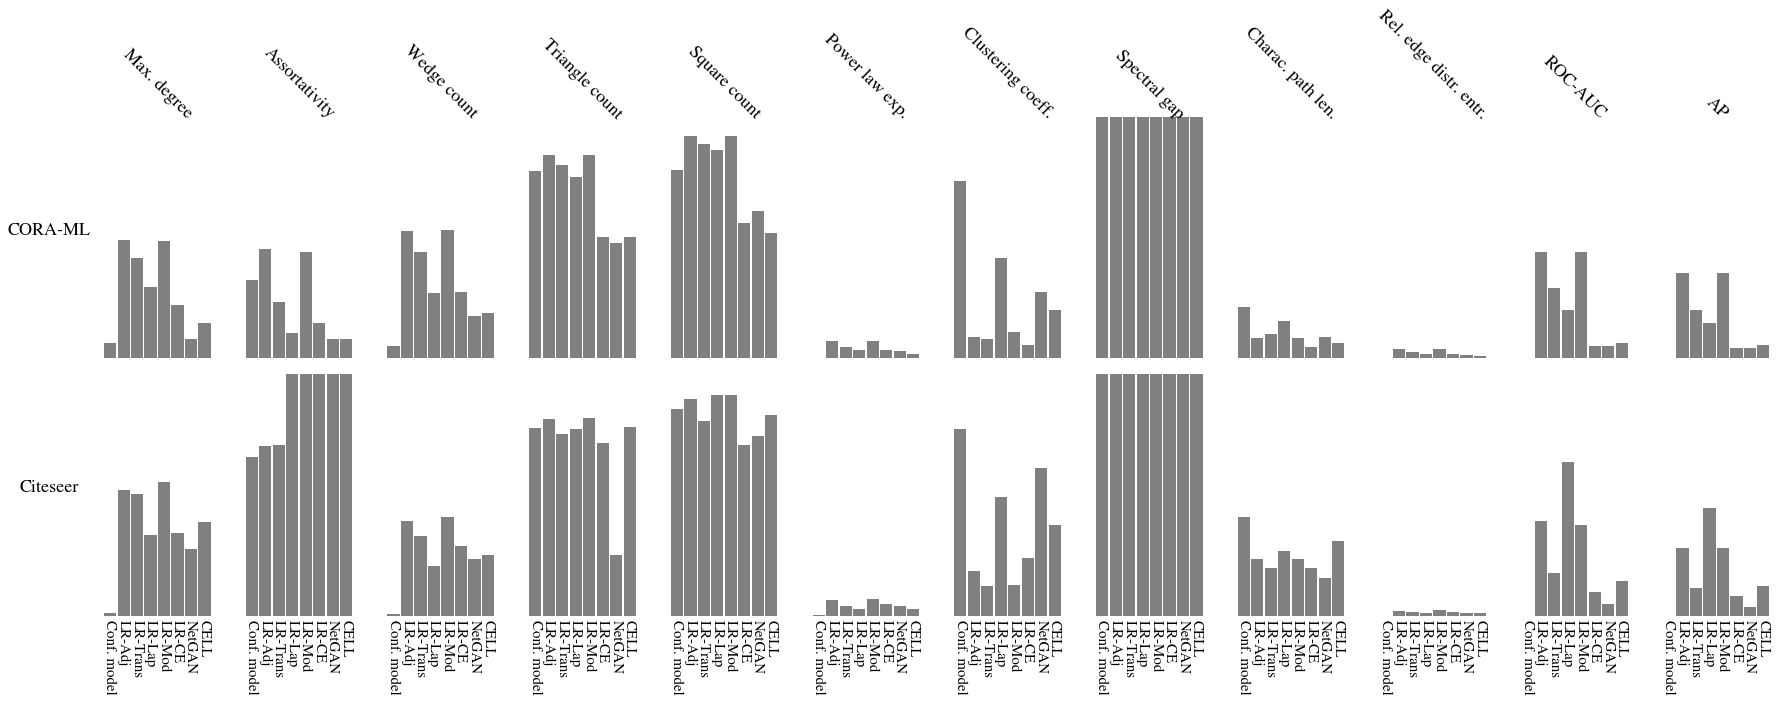

In [10]:
row_names = {'CORA-ML':'CORA-ML', 'citeseer':'Citeseer', 'web_edu':'Web-EDU', 'rt_gop':'RT-GOP', 
             'polblogs':'PolBlogs'}
col_names = {'Clustering Coefficient':'Clustering coeff.',
             'Characteristic Path Length':'Charac. path len.',
             'Edge Distribution Entropy':'Rel. edge distr. entr.',
             'Gini':'Gini coeff.',
             'Max Degree':'Max. degree',
             'Power Law α':'Power law exp.',
             'Spectral Gap':'Spectral gap',
             'Square Count':'Square count',
             'Triangle Count':'Triangle count',
             'Wedge Count':'Wedge count',
             'ROC-AUC Score':'ROC-AUC',
             'Average Precision':'AP'}
model_names = {'baseline_conf':'Conf. model', 'baseline_FA':'LR-Adj', 'baseline_FT':'LR-Trans',
               'baseline_FS':'LR-Lap', 'baseline_FM':'LR-Mod', 'baseline_transition_ce_loss':'LR-CE',
               'baseline_NetGAN_sample_many':'NetGAN', 'Ours':'CELL'}

rel_error_dict = rename_keys(rel_error_dict=rel_error_dict, row_names=row_names, col_names=col_names,
                             model_names=model_names)

sorted_plot = (['CORA-ML', 'Citeseer'], 
               ['Max. degree', 'Assortativity', 'Wedge count', 'Triangle count', 'Square count',
                'Power law exp.', 'Clustering coeff.', 'Spectral gap', 'Charac. path len.', 
                'Rel. edge distr. entr.', 'ROC-AUC', 'AP'],
               ['Conf. model', 'LR-Adj', 'LR-Trans', 'LR-Lap', 'LR-Mod', 
                'LR-CE', 'NetGAN', 'CELL'])

plot_rel_error_dict(rel_error_dict, sorted_plot=sorted_plot, width=1, figsize=(25, 10), colpad=0)